## Unsupvervised Learning: Clustering

Clustering is a class of unsupervised learning methods that associates observations according to some specified measure of similarity (e.g. Euclidean distance).

## K-means Algorithm

The K-means clustering algorithm associates each point $x_i$ in a set of input points $\{x_1, x_2, \ldots, x_m\}$ to $K$ clusters. Each cluster is specified by a **centroid** that is the average location of all the points in the cluster. The algorithm proceeds iteratively from arbitrary centroid locations, updating the membership of each point according to minimum distance, then updating the centroid location based on the new cluster membership. 

The algorithm will have converged when the assignment of points to centroids does not change with each iteration.

### Algorithm

1. Initialize cluster centroids:

    $$\mu^{(0)}_1, \ldots, \mu^{(0)}_k \in \mathbb{R}^n$$

2. Iterate until converged:

    a. Set $c_i = \text{argmin}_j || x_i - \mu_j^{(s)} ||$
    
    b. Update centroids:
    
    $$\mu_j^{(s+1)} = \frac{\sum_{i=1}^m I[c_i = j] x_i}{\sum_{i=1}^m I[c_i = j]}$$

The K-means algorithm is simply a Gaussian mixture model with two restrictions: 

1. the covariance matrix is spherical: 

    $$\Sigma_k = \sigma I_D$$

2. the mixture weights are fixed:

    $$\pi_k = \frac{1}{K}$$

Hence, we are only interested in locating the appropriate centroid of the clusters. This serves to speed computation.

We can define the distortion function:

$$J(c,\mu) = \sum_{i]1}^m ||x_i - \mu_{c_i}||$$

which gets smaller at every iteration. So, k-means is coordinate ascent on $J(c,\mu)$

### Choosing $k$

To check whether a chosen $k$ is reasonable, one approach is to compare the distances between the centroids to the mean distance bewween each data point and their assigned centroid. A good fit involves relatively large inter-centroid distances. 

The appropriate value for k (the number of clusters) may depend on the goals of the analysis, or it may be chosen algorithmically, using an optimization procedure.

## Example: clustering random points

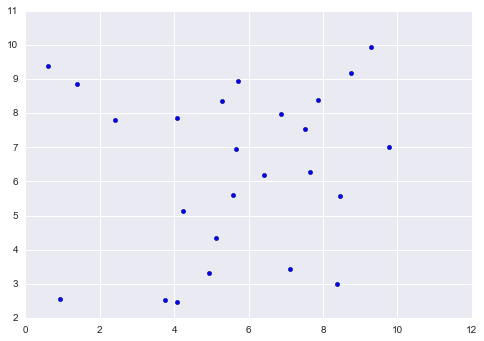

In [62]:
%matplotlib inline
import seaborn as sns; sns.set_context('notebook')
import numpy as np
import matplotlib.pyplot as plt

x, y = np.random.uniform(0, 10, 50).reshape(2, 25)
plt.scatter(x, y)

Let's start with $k=4$, arbitrarily assigned:

In [63]:
centroids = (4, 4), (4, 6), (6, 4)

In [64]:
np.transpose(centroids)

array([[4, 4, 6],
       [4, 6, 4]])

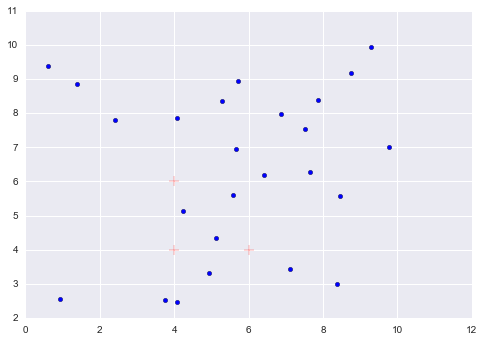

In [65]:
plt.scatter(x, y)
plt.scatter(*np.transpose(centroids), c='r', marker='+', s=100)

We can use the function `cdist` from SciPy to calculate the distances from each point to each centroid.

In [66]:
from scipy.spatial.distance import cdist

distances = cdist(centroids, list(zip(x,y)))
distances.shape

(3, 25)

We can make the initial assignment to centroids by picking the minimum distance.

In [67]:
labels = distances.argmin(axis=0)
labels

array([1, 0, 1, 0, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 0, 1, 2, 1, 0, 1,
       2, 2])

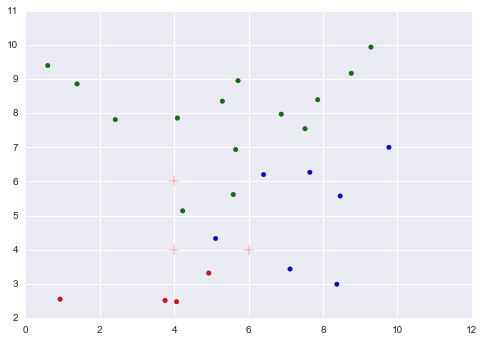

In [68]:
plt.scatter(x, y, c=np.array(list('rgbc'))[labels])
plt.scatter(*np.transpose(centroids), c='r', marker='+', s=100)

Now we can re-assign the centroid locations based on the means of the current members' locations.

In [69]:
new_centroids = [(x[labels==i].mean(), y[labels==i].mean())
                 for i in range(len(centroids))]

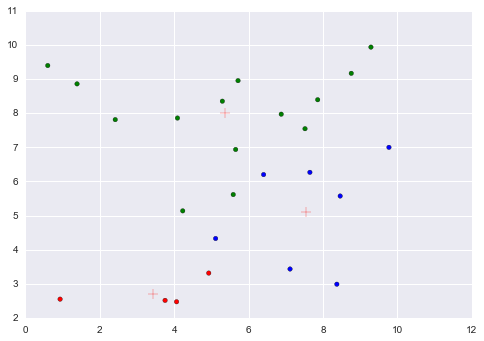

In [70]:
plt.scatter(x, y, c=np.array(list('rgbc'))[labels])
plt.scatter(*np.transpose(new_centroids), c='r', marker='+', s=100)

So, we simply iterate these steps until convergence.

In [71]:
centroids = new_centroids
iterations = 200

for _ in range(iterations):
    distances = cdist(centroids, list(zip(x,y)))
    labels = distances.argmin(axis=0)
    centroids = [(x[labels==i].mean(), y[labels==i].mean())
                 for i in range(len(centroids))]

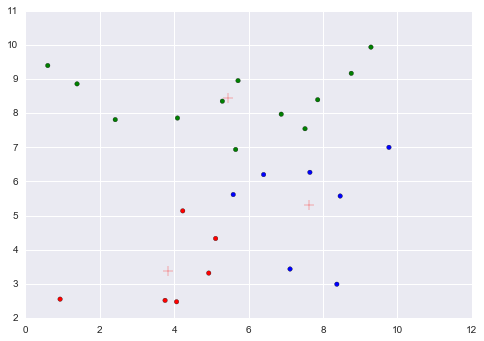

In [72]:
plt.scatter(x, y, c=np.array(list('rgbc'))[labels])
plt.scatter(*np.transpose(centroids), c='r', marker='+', s=100)

## k-means using `scikit-learn`

The `scikit-learn` package includes a `KMeans` class for flexibly fitting K-means models. It includes additional features, such as initialization options and the ability to set the convergence tolerance.

In [73]:
from sklearn.cluster import KMeans
from numpy.random import RandomState
rng = RandomState(1)

# Instantiate model
kmeans = KMeans(n_clusters=3, random_state=rng)
# Fit model
kmeans.fit(np.transpose((x,y)))

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=10,
    n_jobs=1, precompute_distances='auto',
    random_state=<mtrand.RandomState object at 0x10c3eb990>, tol=0.0001,
    verbose=0)

After fitting, we can retrieve the labels and cluster centers.

In [74]:
kmeans.labels_

array([2, 1, 1, 1, 1, 0, 2, 1, 0, 0, 0, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2,
       1, 2], dtype=int32)

In [75]:
kmeans.cluster_centers_

array([[ 2.12161166,  8.48191426],
       [ 4.89799566,  3.59243794],
       [ 7.4358148 ,  7.69161203]])

The resulting plot should look very similar to the one we fit by hand.

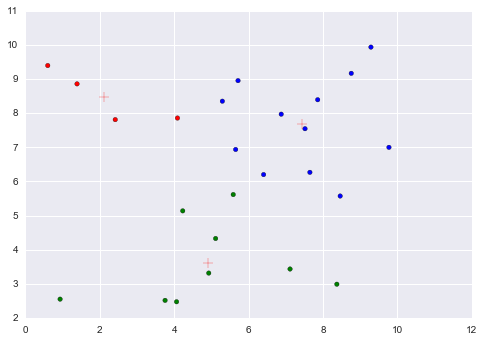

In [76]:
plt.scatter(x, y, c=np.array(list('rgbc'))[kmeans.labels_])
plt.scatter(*kmeans.cluster_centers_.T, c='r', marker='+', s=100)

## Example: Microbiome data

The `microbiome.csv` dataset contains counts of various microbe taxa extraced from either tissue or stool samples of NICU infants. We might be interested in seeing if samples cluster into groups approximately corresponding to location (tissue or stool) based on the counts of each bacterial taxon.

In [77]:
import pandas as pd

microbiome = pd.read_csv("../data/microbiome.csv")

First, we need to transpose the data so that it can be used with `scikit-learn`'s interface. Fortunately, Pandas makes this relatively painless. The data are stored in *long* format:

In [78]:
microbiome.head()

,Taxon,Patient,Group,Tissue,Stool
0,Firmicutes,1,0,136,4182
1,Firmicutes,2,1,1174,703
2,Firmicutes,3,0,408,3946
3,Firmicutes,4,1,831,8605
4,Firmicutes,5,0,693,50


For this analysis, we need the features (*i.e.* taxa) in columns, with a row for each sample. First we drop the `Group` column, then pivot the `Taxon` column into a column index. 

In [79]:
microbiome_pivoted.pivot?

Object `microbiome_pivoted.pivot` not found.


In [80]:
microbiome_pivoted = microbiome.drop('Group', axis=1).pivot(index='Patient', 
                        columns='Taxon').stack(level=0).reset_index()
microbiome_pivoted.columns.name = None
microbiome_pivoted.head()

,Patient,level_1,Actinobacteria,Bacteroidetes,Firmicutes,Other,Proteobacteria
0,1,Tissue,1590,67,136,195,2469
1,1,Stool,4,0,4182,18,1821
2,2,Tissue,25,0,1174,42,839
3,2,Stool,2,0,703,2,661
4,3,Tissue,259,85,408,316,4414


Then we drop the unused column and change the location variable from `str` type to `int`.

In [81]:
microbiome_data = microbiome_pivoted.drop('Patient', 
                        axis=1).rename(columns={'level_1':'Location'}
                                       ).replace({'Tissue': 0 , 'Stool':1})

y = microbiome_data.values[:, 0]
X = microbiome_data.values[:, 1:]

In [82]:
microbiome_data.head()

,Location,Actinobacteria,Bacteroidetes,Firmicutes,Other,Proteobacteria
0,0,1590,67,136,195,2469
1,1,4,0,4182,18,1821
2,0,25,0,1174,42,839
3,1,2,0,703,2,661
4,0,259,85,408,316,4414


To simplify the analysis, and aid visualization, we will again perform a PCA to isolate the majority of the variation into two principal components.

In [83]:
from sklearn.decomposition import PCA
from itertools import cycle

pca = PCA(n_components=2, whiten=True).fit(X)
X_pca = pca.transform(X)

def plot_2D(data, target, target_names, pca):
    colors = cycle('rgbcmykw')
    target_ids = range(len(target_names))
    plt.figure()
    for i, c, label in zip(target_ids, colors, target_names):
        plt.scatter(data[target == i, 0], data[target == i, 1],
                   c=c, label=label)
    var_explained = pca.explained_variance_ratio_ * 100
    plt.xlabel('First Component: {0:.1f}%'.format(var_explained[0]))
    plt.ylabel('Second Component: {0:.1f}%'.format(var_explained[1]))
    plt.legend()

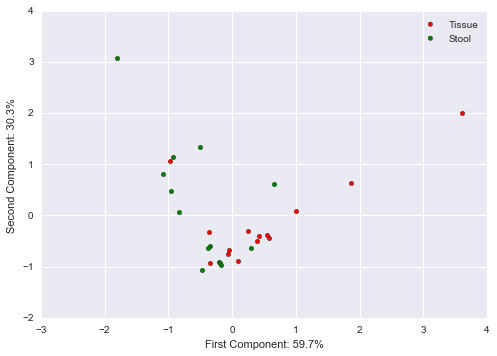

In [84]:
plot_2D(X_pca, y, ['Tissue', 'Stool'], pca)

We can now create a `KMeans` object with `k=2`, and fit the data with it.

In [85]:
km_microbiome = KMeans(n_clusters=2, random_state=rng)
km_microbiome.fit(X_pca)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=2, n_init=10,
    n_jobs=1, precompute_distances='auto',
    random_state=<mtrand.RandomState object at 0x10c3eb990>, tol=0.0001,
    verbose=0)

From this, we can extract the cluster centroids (in the `cluster_center_` attribute) and the group labels (in `labels_`) in order to generate a plot of the classification result.

In [86]:
np.round(km_microbiome.cluster_centers_, decimals=2)

array([[ 0.34, -0.38],
       [-1.01,  1.14]])

In [87]:
km_microbiome.labels_

array([0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 1], dtype=int32)

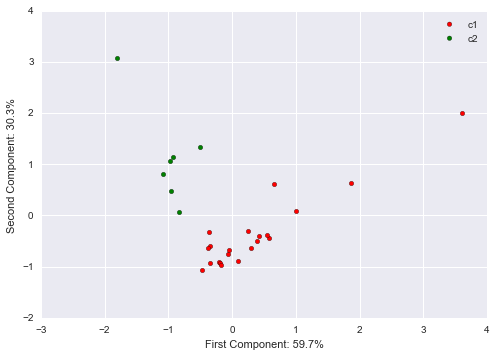

In [88]:
plot_2D(X_pca, km_microbiome.labels_, ["c1", "c2"], pca)

`scikit-learn` includes a suite of well-known clustering algorithms. Like most unsupervised learning models in the scikit, they expect the data to be clustered to have the shape `(n_samples, n_features)`:

- `sklearn.cluster.KMeans`
: The simplest, yet effective clustering algorithm. Needs to be provided with the
number of clusters in advance, and assumes that the data is normalized as input
(but use a PCA model as preprocessor).
- `sklearn.cluster.MeanShift`
: Can find better looking clusters than KMeans but is not scalable to high number of samples.
- `sklearn.cluster.DBSCAN`
: Can detect irregularly shaped clusters based on density, i.e. sparse regions in
the input space are likely to become inter-cluster boundaries. Can also detect
outliers (samples that are not part of a cluster).

## Exercise: NEC

If all the odd-numbered patients are healthy controls and the even-numbered patients have necrotizing enterocolitis (NEC), see if either the tissue or stool samples cluster according to group status.

In [ ]:
## Write answer here

## Exercise: clustering baseball statistics

We can use clustering to try to find interesting groupings among sets of baseball statistics. Load the baseball dataset and run a clustering algorithm on the set of three statistics:

* hit rate: hits / at bats
* strikeout rate: strikeouts / at bats
* walk rate: bases on balls /at bats

You should probably set a minimum number of at bats to qualify for the analysis, since there are pitchers that get only a handful of at bats each year.

Since we are clustering in 3 dimensions, you can visualize the output as a series of pairwise plots.

In [ ]:
import pandas as pd

baseball = pd.read_csv("../data/baseball.csv", index_col=0)
baseball.head()

In [ ]:
## Write answer here